In [ ]:
import time

# visualizatoin 
import matplotlib.pyplot as plt 

# data wrangling
import pandas as pd
import numpy as np 

# data preprocessing
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import VarianceThreshold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# learning
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# evaluation
from sklearn.metrics import RocCurveDisplay, auc
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import brier_score_loss
from sklearn.metrics import precision_score, confusion_matrix
from sklearn.metrics import accuracy_score, recall_score

# explainability
import shap
from sklearn.inspection import PartialDependenceDisplay
#https://www.kaggle.com/code/bryanb/xgboost-explainability-with-shap


# Load data
If you put the data set in the same folder as this notebook, you can use the following code to load the data set. 

In [ ]:
# description
description = pd.read_csv('WiDS_Datathon_2020_Dictionary.csv')
description_dict = description.set_index('Variable Name').to_dict(orient='index')
# data
df = pd.read_csv('training_v2.csv')

df.head()

In [ ]:
# A bit of data exploration, count the amount of data entries per potentially sensitive group.
# Check for bias.
df['ethnicity'].value_counts()


In [ ]:
df['gender'].value_counts()

In [ ]:
df['age'].plot.kde(xlim=(0, 100), ylim=(0, 0.025)).set_xlabel('age')
# plt.savefig('age_density_plot.svg')

In [ ]:
df_death = df[df['hospital_death'] == 1]
df_alive = df[df['hospital_death'] == 0]
ax1 = df_death['age'].plot.kde(xlim=(0, 100), ylim=(0, 0.03))
ax2 = df_alive['age'].plot.kde(xlim=(0, 100), ylim=(0, 0.03))
ax1.set_xlabel('age')
ax1.legend(labels = ['Dead', 'Alive'])
plt.show()
number_dead = len(df_death['age'])
number_alive = len(df_alive['age'])
print(f'Dead: {number_dead}')
print(f'Alive: {number_alive}')
#plt.savefig('age_death_density_plot.svg')

In [ ]:
df_death['gender'].value_counts()

In [ ]:

ethnicity_death = {}
for key in df_death['ethnicity']:
    if key not in ethnicity_death.keys():
        ethnicity_death[key] = 0
    else:
        ethnicity_death[key] += 1 
plt.pie(ethnicity_death.values(), labels=ethnicity_death.keys())
plt.show()

df_death['ethnicity'].value_counts()


In [ ]:
df_ethnicity_caucasian = df.loc[df['ethnicity'].isin(['Caucasian'])]
df_ethnicity_african_american = df.loc[df['ethnicity'].isin(['African American'])]
df_ethnicity_hispanic = df.loc[df['ethnicity'].isin(['Hispanic'])]
df_ethnicity_other_unknown = df.loc[df['ethnicity'].isin(['Other/Unknown'])]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

ax1 = df_ethnicity_caucasian['age'].plot.kde(xlim=(0, 100), ylim=(0, 0.025), color='red', ax=axes[0, 0]).set_xlabel('age')
ax2 = df_ethnicity_african_american['age'].plot.kde(xlim=(0, 100), ylim=(0, 0.025), color='blue', ax=axes[0, 1]).set_xlabel('age')
ax3 = df_ethnicity_hispanic['age'].plot.kde(xlim=(0, 100), ylim=(0, 0.025), color='green', ax=axes[1, 0]).set_xlabel('age')
ax4 = df_ethnicity_other_unknown['age'].plot.kde(xlim=(0, 100), ylim=(0, 0.025), color='orange', ax=axes[1, 1]).set_xlabel('age')

df_death_ethnicity_caucasian = df_death.loc[df['ethnicity'].isin(['Caucasian'])]
df_death_ethnicity_african_american = df_death.loc[df['ethnicity'].isin(['African American'])]
df_death_ethnicity_hispanic = df_death.loc[df['ethnicity'].isin(['Hispanic'])]
df_death_ethnicity_other_unknown = df_death.loc[df['ethnicity'].isin(['Other/Unknown'])]

ax1_death = df_death_ethnicity_caucasian['age'].plot.kde(xlim=(0, 100), ylim=(0, 0.035), linestyle='--', color='red', ax=axes[0, 0])
ax2_death = df_death_ethnicity_african_american['age'].plot.kde(xlim=(0, 100), ylim=(0, 0.035), linestyle='--', color='blue', ax=axes[0, 1])
ax3_death = df_death_ethnicity_hispanic['age'].plot.kde(xlim=(0, 100), ylim=(0, 0.035), linestyle='--', color='green', ax=axes[1, 0])
ax4_death = df_death_ethnicity_other_unknown['age'].plot.kde(xlim=(0, 100), ylim=(0, 0.035), linestyle='--',color='orange', ax=axes[1, 1])

axes[0, 0].legend(['Caucasian_all', 'Caucasian_dead'], loc='upper right')
axes[0, 1].legend(['African American_all', 'African American_dead'], loc='upper right')
axes[1, 0].legend(['Hispanic_all', 'Hispanic_dead'], loc='upper right')
axes[1, 1].legend(['Other/Unknown_all', 'Other/Unknown_dead'], loc='upper right')

In [ ]:
df_death = df[df['hospital_death'] == 1]
df_alive = df[df['hospital_death'] == 0]

df_all_gender_f = df.loc[df['gender'] == 'F']
df_alive_gender_f = df_alive.loc[df_alive['gender'] == 'F']
df_death_gender_f = df_death.loc[df_death['gender'] == 'F']

df_all_gender_m = df.loc[df['gender'] == 'M']
df_alive_gender_m = df_alive.loc[df_alive['gender'] == 'M']
df_death_gender_m = df_death.loc[df_death['gender'] == 'M']

ax1 = df_all_gender_f['age'].plot.kde(xlim=(0, 100), ylim=(0, 0.03))
ax2 = df_all_gender_m['age'].plot.kde(xlim=(0, 100), ylim=(0, 0.03))
ax1.set_xlabel('age')
ax1.legend(labels = ['F all', 'M all'])
plt.show()


In [ ]:
ax1 = df_alive_gender_f['age'].plot.kde(xlim=(0, 100), ylim=(0, 0.03))
ax2 = df_alive_gender_m['age'].plot.kde(xlim=(0, 100), ylim=(0, 0.03))
ax1.set_xlabel('age')
ax1.legend(labels = ['F alive', 'M alive'])
plt.show()

In [ ]:
ax1 = df_death_gender_f['age'].plot.kde(xlim=(0, 100), ylim=(0, 0.03))
ax2 = df_death_gender_m['age'].plot.kde(xlim=(0, 100), ylim=(0, 0.03))
ax1.set_xlabel('age')
ax1.legend(labels = ['F dead', 'M dead'])
plt.show()

In [ ]:
df_death['icu_type'].value_counts()

In [ ]:
df_icu_type_Med_Surg = df.loc[df['icu_type']=='Med-Surg ICU']
df_icu_type_MICU = df.loc[df['icu_type']=='MICU']
df_icu_type_NEURO = df.loc[df['icu_type']=='Neuro ICU']
df_icu_type_CCU_CT = df.loc[df['icu_type']=='CCU-CTICU']
df_icu_type_Cardiac = df.loc[df['icu_type']=='Cardiac ICU']
df_icu_type_S = df.loc[df['icu_type']=='SICU']
df_icu_type_CS = df.loc[df['icu_type']=='CSICU']
df_icu_type_CT = df.loc[df['icu_type']=='CTICU']


values_icu_deaths = df_death['icu_type'].value_counts()
Med_Surg_death_rate = values_icu_deaths.iloc[0] / len(df_icu_type_Med_Surg)
MICU_death_rate = values_icu_deaths.iloc[1] / len(df_icu_type_MICU)
NEURO_death_rate =  values_icu_deaths.iloc[2] / len(df_icu_type_NEURO)
CCU_death_rate = values_icu_deaths.iloc[3] / len(df_icu_type_CCU_CT)
Cardiac_death_rate = values_icu_deaths.iloc[4] / len(df_icu_type_Cardiac)
S_death_rate = values_icu_deaths.iloc[5] / len(df_icu_type_S)
CS_death_rate = values_icu_deaths.iloc[6] / len(df_icu_type_CS)
CT_death_rate = values_icu_deaths.iloc[7] / len(df_icu_type_CT)

print(f"MICU death rate:              {round(MICU_death_rate, 4)} ")
print(f"Cardiac death rate:           {round(Cardiac_death_rate, 4)}")
print(f"Medical surgery death rate:   {round(Med_Surg_death_rate, 4)} ")
print(f"NEURO death rate:             {round(NEURO_death_rate, 4)}")
print(f"CCU_CT death rate:            {round(CCU_death_rate, 4)}")
print(f"S death rate:                 {round(S_death_rate, 4)}")
print(f"CT death rate:                {round(CT_death_rate, 4)}")
print(f"CS death rate:                {round(CS_death_rate, 4)}")

In [ ]:
df_death['readmission_status'].value_counts()

The dataset contains many different variables, including:

#### Target variable
* *hospital_death*: 'Whether the patient died during this hospitalization'.

#### Identifiers
* *patient_id*: Unique identifier associated with a patient
* *encounter_id*: Unique identifier associated with a patient unit stay
* *hospital_id*: Unique identifier associated with a hospital
* *icu_id*: A unique identifier for the unit to which the patient was admitted

#### Demographics
* *age*: The age of the patient on unit admission.
* *bmi*: The body mass index of the person on unit admission.
* *ethnicity*: The common national or cultural tradition which the person belongs to.
* *gender*: The genotypical sex of the patient.
* *height*: The height of the person on unit admission

#### Health indicators
A few examples:
* *elective_surgery*: Whether the patient was admitted to the hospital for an elective surgical operation
* *h1_diasbp_invasive_max*: The patient's highest diastolic blood pressure during the first hour of their unit stay, invasively measured
* *h1_diasbp_invasive_min*: The patient's lowest diastolic blood pressure during the first hour of their unit stay, invasively measured
* *gcs_verbal_apache*: The verbal component of the Glasgow Coma Scale measured during the first 24 hours which results in the highest APACHE III score
* *immunosuppression*: Whether the patient has their immune system suppressed within six months prior to ICU admission for any of the following reasons; radiation therapy, chemotherapy, use of non-cytotoxic immunosuppressive drugs, high dose steroids (at least 0.3 mg/kg/day of methylprednisolone or equivalent for at least 6 months).

In [68]:
# you can retrieve the description of a variable in the data set from the description dictionary as follows
description_dict

{'encounter_id': {'Category': 'identifier',
  'Unit of Measure': nan,
  'Data Type': 'integer',
  'Description': 'Unique identifier associated with a patient unit stay',
  'Example': nan},
 'hospital_id': {'Category': 'identifier',
  'Unit of Measure': nan,
  'Data Type': 'integer',
  'Description': 'Unique identifier associated with a hospital',
  'Example': nan},
 'patient_id': {'Category': 'identifier',
  'Unit of Measure': nan,
  'Data Type': 'integer',
  'Description': 'Unique identifier associated with a patient',
  'Example': nan},
 'hospital_death': {'Category': 'demographic',
  'Unit of Measure': nan,
  'Data Type': 'binary',
  'Description': 'Whether the patient died during this hospitalization',
  'Example': '0'},
 'age': {'Category': 'demographic',
  'Unit of Measure': 'Years',
  'Data Type': 'numeric',
  'Description': 'The age of the patient on unit admission',
  'Example': nan},
 'bmi': {'Category': 'demographic',
  'Unit of Measure': 'kilograms/metres^2',
  'Data Type':

In [ ]:
description_dict["apache_4a_hospital_death_prob"]

In [ ]:
description_dict["apache_4a_hospital_death_prob"]

In [ ]:
description_dict["apache_3j_bodysystem"]

# Pre-processing
This is a real-world data set, meaning that it is **messy**. Two key difficulties are categorial features and missing values.

> **To avoid information leakage, any pre-processing steps must be based on the training data only.** For example, when we compute the mean, this must be computed based on the training data set.

### Categorical Features
Many (implementations of) machine learning algorithms cannot handle categorical features automatically. This is often dealt with through *one-hot-encoding*, where each category of a feature is transformed into a binary feature.

When a feature contains many categories, this results in a very sparse data set with many features. As such, it can be worthwile to use domain expertise to merge particular categories in order to reduce the number of one-hot-encoded features.

### Missing Values
The data set contains a lot of missing values (around 35% of the values is missing). There are several ways to deal with this, some ideas to try:

* Replace missing values with the mean (numerical features) or median (categorical features), e.g., using [`SimpleImputer`](https://scikit-learn.org/stable/modules/impute.html#univariate-feature-imputation).
* Drop features with many missing values.
* Model-based imputation strategies, such as [KNNImputer](https://scikit-learn.org/stable/modules/impute.html#nearest-neighbors-imputation).
* Domain-knowledge inspired replacement. For example, for features related to medical measurements, it is expected that the entered data is abnormal in some way. As such, replacing by the mean or median can paint a skewed picture. One way to deal with this would be to identify a normal range for different measurements, based on domain expertise. *Note: this is a very time consuming strategy which we do not necessarily recommend in the time span of this project.*

We encourage you to try several approaches and see what works best.

## Example of  Minimal Pre-Processing
Below you can find an example of pre-processing the data set for classification. We showcase both 'manual' pre-processing steps through `pandas` as well as a (small) scikit-learn `Pipeline`. Feel free to use whatever you are most comfortable with in your project.

In [ ]:
test_size = 0.2 # proportion for train versus test+val split
val_size = 0.5 # proportion for test versus val split
random_state = 42  # random state is used to set a seed for randomness, which is only relevant for reproducibility purposes
max_missing = 0.8  # maximum percentage of missing values for a column to be dropped

In [ ]:
start_time = time.time()

# save features
X = df.copy().drop(['hospital_death', # drop target variable
                    'patient_id', 'encounter_id', 'hospital_id', 'icu_id', # drop identifiers
                    'apache_4a_hospital_death_prob', 'apache_4a_icu_death_prob', # drop APACHE scores
                    'apache_2_bodysystem'], # drop because of similarity with apache_3j_bodysystem
                   axis=1)
# save target variable
y = df['hospital_death'].copy()
# save APACHE scores for later evaluation on train / test / validation data
y_apache = df['apache_4a_hospital_death_prob'].copy()

""" SPLIT DATA SET """
# split the dataset into train and test+validation set
(
    X_train,
    X_test,
    y_train,
    y_test,
    y_apache_train,
    y_apache_test,
    ) = train_test_split(X, y, y_apache, 
                         test_size=test_size, # used for testing and validation
                         random_state=random_state # for reproducibility
                        ) 
# split the test set into test + validation set
(
    X_val,
    X_test,
    y_val,
    y_test,
    y_apache_val,
    y_apache_test,
    ) = train_test_split(X_test, y_test, y_apache_test, 
                         test_size=val_size, # used for testing and validation
                         random_state=random_state # for reproducibility
                        ) 

"""MISSING VALUES"""
# drop columns with many missing values
missing = X_train.isna().sum() > max_missing * len(X_train)
missing = missing[missing].index
X_train = X_train.drop(missing, axis=1)
X_val = X_val.drop(missing, axis=1)
X_test = X_test.drop(missing, axis=1)

"""FURTHER PROCESSING PIPELINE"""
# define pre-processing steps for numerical features
num_transformer = Pipeline(steps=[("constant", VarianceThreshold()), # remove constant features
                                  ("imputer", SimpleImputer(strategy="mean")),
#                                   ("scaler", StandardScaler())
                                 ])
# define preprocessing steps for categorical features
cat_transformer = Pipeline(steps=[("encoder", OneHotEncoder(handle_unknown="ignore"))])
# create preprocessing pipeline
prep_pipeline = ColumnTransformer(
    transformers=[
        ('num', num_transformer, make_column_selector(dtype_exclude=object)), # apply to columns NOT of type object (int or float)
        ('cat', cat_transformer, make_column_selector(dtype_include=object)) # apply to columns of type object
    ])
# pipeline
prep_pipeline.fit(X_train, y_train)
# display(prep_pipeline) # display preprocessing pipeline

# transform data sets
X_train = pd.DataFrame(prep_pipeline.transform(X_train), columns=prep_pipeline.get_feature_names_out())
X_val = pd.DataFrame(prep_pipeline.transform(X_val), columns=prep_pipeline.get_feature_names_out())
X_test = pd.DataFrame(prep_pipeline.transform(X_test), columns=prep_pipeline.get_feature_names_out())
        
"""PRINT STATS"""
print("Time: %.2fs" % (time.time() - start_time))
print("Train set: %s rows, %s columns" % X_train.shape)
print("Validation set: %s rows, %s columns" % X_val.shape)
print("Test set: %s rows, %s columns" % X_test.shape)

In [ ]:
X_train

## Simple Logistic Regression Model
We can now train a simple logistic regression model.

> **Warning**. The following code will lead to a convergence warning. To solve this "issue", you can increase `max_iter` and/or apply a `sklearn.preprocessing.StandardScaler()`. However, the model still performance reasonably well even without convergence.

In [ ]:
start_time = time.time()

# train logistic regression model
lr = LogisticRegression(penalty='l1', solver='saga')
lr.fit(X_train, y_train)

print("Time: %.2fs" % (time.time() - start_time))

In [ ]:
# Print most 
print(lr.feature_names_in_.shape)
print(lr.coef_[0].shape)
coefficients = pd.DataFrame({"feature": lr.feature_names_in_, "coefficient": lr.coef_[0]})
coefficients.sort_values(by="coefficient", key=np.abs, ascending=False).head(20)


In [ ]:
# histogram
y_apache_train.hist()
plt.title("APACHE scores (train)")
plt.show()

# APACHE IV Scores
APACHE ("Acute Physiology and Chronic Health Evaluation") is a scoring system assessing severity of illness and prognoses of ICU patients. The scoring system has been improved over time, with APACHE II being released in 1985, APACHE III in 1991, and finally APACHE IV in 2006. APACHE IV has been evaluated and validated in patients for mortality outcome. 

In the dataset, the *apache_4a_hospital_death_prob* column corresponds to the APACHE IV probabilistic prediction of in-hospital mortality for the patient which utilizes the APACHE III score and other covariates, including diagnosis.
* `-1` means the score couldn't be calculated for some reason. In particular, the patient encounter could have been a re-admission. 
* `NaN` indicates a missing score, due to e.g., a missing covariate that made it impossible to compute the score. 


## Some additional histograms for exploration

In [ ]:
# histogram
plt.hist(y_apache_train, range=[0, 1], bins=20, )#log=True)
plt.title("APACHE scores (train)")
plt.show()

In [ ]:
# histogram
data = [y_apache_train[y_train==1], y_apache_train[y_train==0]]
plt.hist(data, range=[0, 1], bins=20)
plt.legend(["Died in hospital", "Survived"])
plt.title("APACHE scores (train)")
plt.show()

In [ ]:
# histogram
plt.hist(y_apache_train[y_train==1], range=[0, 1], bins=20)
plt.legend(["Died in hospital"])
plt.title("APACHE scores (train)")
plt.show()

In [ ]:
from sklearn.calibration import CalibrationDisplay

display = CalibrationDisplay.from_predictions(
    y_train, 
    y_apache_train, 
    n_bins=20
).plot
plt.title("Calibration of APACHE scores (train)")
plt.show()

In [ ]:
# calibration of logistic regression on validation data
# compared to APACHE calibration
y_lr_val = lr.predict_proba(X_val)[:,1]
fig, ax = plt.subplots(figsize=(6, 6))
lr_calibration = CalibrationDisplay.from_predictions(
    y_val[y_apache_val >= 0], 
    y_apache_val[y_apache_val >= 0],
    n_bins=20,
    name="APACHE",
    ax=ax
).plot
lr_calibration = CalibrationDisplay.from_predictions(
    y_val, 
    y_lr_val,
    n_bins=20,
    name="Logistic regression",
    ax=ax
).plot
plt.title("Calibration (validation)")
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))
RocCurveDisplay.from_predictions(
    y_val[y_apache_val >= 0], 
    y_apache_val[y_apache_val >= 0], 
    name=f"APACHE",
    ax=ax)
RocCurveDisplay.from_predictions(
    y_val, 
    y_lr_val,
    name=f"Logistic regression",
    ax=ax)
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC (validation)")
plt.legend()
plt.show()

# Models

## Decision Tree

In [ ]:
print(y_train)

In [ ]:
# create balanced dataset by downsampling
y_train_i = y_train.reindex(X_train.index)
y_train_dead  = y_train_i[y_train_i==1]
y_train_alive = y_train_i[y_train_i==0] 
y_train_alive_pruned = y_train_alive.sample(len(y_train_dead))
y_train_balanced = pd.concat([y_train_dead, y_train_alive_pruned])
X_train_balanced = X_train.loc[y_train_balanced.index, :]

In [ ]:

decision_tree = tree.DecisionTreeClassifier(
    criterion = "entropy",
    max_depth = 10,
    min_samples_split = 400
)
decision_tree_balanced = tree.DecisionTreeClassifier(
    criterion = "entropy",
    max_depth = 10,
    min_samples_split = 1000,
    class_weight='balanced'
)
decision_tree_balanced_downsample = tree.DecisionTreeClassifier(
    criterion = "entropy",
    max_depth = 10,
    min_samples_split = 100
)
decision_tree.fit(X_train, y_train)
decision_tree_balanced.fit(X_train, y_train)
decision_tree_balanced_downsample.fit(X_train_balanced, y_train_balanced)
print(
    "                    D.Tree   Balanced Downsampled"
    "\nbalanced accuracy: ",
    f'{balanced_accuracy_score(y_val, decision_tree.predict(X_val)):.3f}   ',
    f'{balanced_accuracy_score(y_val, decision_tree_balanced.predict(X_val)):.3f}   ',
    f'{balanced_accuracy_score(y_val, decision_tree_balanced_downsample.predict(X_val)):.3f}   ',
    "\nF1 score:          ",
    f'{f1_score(y_val, decision_tree.predict(X_val)):.3f}   ',
    f'{f1_score(y_val, decision_tree_balanced.predict(X_val)):.3f}   ',
    f'{f1_score(y_val, decision_tree_balanced_downsample.predict(X_val)):.3f}   ',
    "\nBrier score:       ",
    f'{brier_score_loss(y_val, decision_tree.predict_proba(X_val)[:,1]):.3f}   ',
    f'{brier_score_loss(y_val, decision_tree_balanced.predict_proba(X_val)[:,1]):.3f}   ',
    f'{brier_score_loss(y_val, decision_tree_balanced_downsample.predict_proba(X_val)[:,1]):.3f}   ',
    "\nAUC score:         ",
    f'{roc_auc_score(y_val, decision_tree.predict_proba(X_val)[:,1]):.3f}   ',
    f'{roc_auc_score(y_val, decision_tree_balanced.predict_proba(X_val)[:,1]):.3f}   ',
    f'{roc_auc_score(y_val, decision_tree_balanced_downsample.predict_proba(X_val)[:,1]):.3f}   ',
)

In [ ]:
# tree.plot_tree(decision_tree)
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ConfusionMatrixDisplay.from_estimator(
    decision_tree,
    X_val, y_val, normalize='true',
    ax=ax[0]
)
ConfusionMatrixDisplay.from_estimator(
    decision_tree_balanced,
    X_val, y_val, normalize='true',
    ax=ax[1]
)
ax[0].set_title("Decision tree\nConfusion matrix (validation)")
ax[1].set_title("Balanced decision tree\nConfusion matrix (validation)")
plt.show()

In [ ]:
# calibration of decision tree on validation data
# compared to APACHE calibration
y_dt_val  = decision_tree.predict_proba(X_val)[:,1]
y_bdt_val = decision_tree_balanced.predict_proba(X_val)[:,1]
n_bins=20
fig, ax = plt.subplots(figsize=(6, 6))
dt_calibration = CalibrationDisplay.from_predictions(
    y_val, 
    y_dt_val,
    n_bins=n_bins,
    name="Decision tree classifier",
    ax=ax
).plot
bdt_calibration = CalibrationDisplay.from_predictions(
    y_val, 
    y_bdt_val,
    n_bins=n_bins,
    name="Balanced decision tree classifier",
    ax=ax
).plot
plt.title("Calibration (validation)")
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))
RocCurveDisplay.from_predictions(
    y_val, 
    y_dt_val,
    name=f"Decision tree classifier",
    ax=ax)
RocCurveDisplay.from_predictions(
    y_val, 
    y_bdt_val,
    name=f"Balanced decision tree classifier",
    ax=ax)
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC (validation)")
plt.legend()
plt.show()

## Logistic regression

In [ ]:
pipe = Pipeline([
    ("scaler", StandardScaler()), # standardizes the data by scaling each feature to have zero mean and unit variance

    # selects the most important features based on the L1 regularization path of a logistic regression model with 
    # the liblinear solver (uses a coordinate descent algorithm); 
    ("feature_selection", SelectFromModel(LogisticRegression(penalty="l1", solver="liblinear"))),

    # train on selected features (L2 regularization)
    ("model", LogisticRegression(penalty="l2", solver="lbfgs", max_iter = 1000))
])

pipe.fit(X_train, y_train)

In [ ]:
y_pred = pipe.predict(X_val)

In [ ]:
accuracy = pipe.score(X_val, y_val)
print("Accuracy:", accuracy)

f1 = f1_score(y_val, y_pred)
print("F1 score:", f1)

precision = precision_score(y_val, y_pred)

print("Precision:", precision) # % of true positive out of all positive


In [ ]:
y_pred_probabilities = pipe.predict_proba(X_val)[:, 1]

auc = roc_auc_score(y_val, y_pred_probabilities)
print("AUC:", auc)

fpr, tpr, thresholds = roc_curve(y_val, y_pred_probabilities)

# create the ROC curve display object
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr)

# plot the ROC curve
roc_display.plot(label = "Logistic Regression")


plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC (validation)")
plt.axis("square")
plt.legend()
plt.show()

In [ ]:
cm = confusion_matrix(y_val, y_pred, normalize='true')
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe.classes_).plot()
plt.title("Logistic regression confusion matrix (validation)")
plt.show()

In [ ]:
selected_features = pipe.named_steps['feature_selection'].get_support()

print("Number of selected features: ", len(selected_features))

## Random forest

In [ ]:
# training 
rf = RandomForestClassifier()
rf.fit(X_train, y_train)


In [ ]:
y_rf_val = rf.predict_proba(X_val)[:, 1]
y_rf_val
roc_auc_score(y_val, y_pred_probabilities)

## XGBoost

In [ ]:
xgb_model = xgb.XGBClassifier(
        learning_rate=0.1,
        n_estimators=300,
        max_depth=3,
        min_child_weight=3,
        gamma=0.2,
        subsample=0.8,
        colsample_bytree=1.0,
        reg_alpha=0.2,
        objective='binary:logistic',
        nthread=4,
        scale_pos_weight=9.2,
        seed=27
)

# train the model
xgb_model.fit(X_train, y_train)

# make predictions on the validation set
y_val_pred = xgb_model.predict(X_val)
y_xgb_pred_proba_val = xgb_model.predict_proba(X_val)[:, 1]

# calculate evaluation metrics on the validation set
val_acc = accuracy_score(y_val, y_val_pred)
val_auc = roc_auc_score(y_val, y_xgb_pred_proba_val)
val_precision = precision_score(y_val, y_val_pred)
val_recall = recall_score(y_val, y_val_pred)

print(y_val)
print(y_val_pred)

print(f"By using tuned parameters, accuracy score: {val_acc}")
print(f"By using tuned parameters, roc_auc_score: {val_auc}")
print(f"By using tuned parameters, precision score: {val_precision}")
print(f"By using tuned parameters, recall score: {val_recall}")

# Model comparison and decision threshold selection

In [ ]:
models = {
    "Logistic regression": y_pred_probabilities,
    "Decision tree": y_dt_val,
    "Balanced decision tree": y_bdt_val,
    "Random forest": y_rf_val,
    "XGBoost": y_xgb_pred_proba_val,
}

fig, ax = plt.subplots(figsize=(6, 6))
for name, y_pred_proba in models.items():
    RocCurveDisplay.from_predictions(
        y_val, 
        y_pred_proba,
        name=name,
        ax=ax
    )
RocCurveDisplay.from_predictions(
        y_val[y_apache_val >= 0], 
        y_apache_val[y_apache >= 0],
        name="APACHE IV",
        ax=ax,
        linestyle='--'
    )
plt.plot([0, 1], [0, 1], "k--", label="Chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC (validation)")
plt.legend()
plt.show()

In [ ]:
m = 100

utility_curves = {model: np.empty(m) for model in models}
fnr_curves = {model: np.empty(m) for model in models}
accuracy_curves = {model: np.empty(m) for model in models}

def utility_score_from_confusion_matrix(cm):
    tn = cm[0][0] # true negatives
    fn = cm[1][0] # false negatives
    tp = cm[1][1] # true positives
    fp = cm[0][1] # false positives
    return (-10 * fn -1 * fp) / (tn + fn + tp + fp)

x = np.linspace(0, 1, m)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

for name, y_pred_proba in models.items():
    for i, decision_threshold in enumerate(x):
        cm = confusion_matrix(y_val, y_pred_proba >= decision_threshold)
        utility_curves[name][i] = utility_score_from_confusion_matrix(cm)
        fnr_curves[name][i] = cm[1][0] / (cm[1][0] + cm[1][1])
        accuracy_curves[name][i] = (cm[0][0] + cm[1][1]) / cm.flatten().sum()
    ax[0].plot(x, fnr_curves[name])
    ax[1].plot(x, accuracy_curves[name])
    # ax[2].plot(x, utility_curves[name])
# for APACHE
utility_curve_apache = np.empty(m)
fnr_curve_apache = np.empty(m)
accuracy_curve_apache = np.empty(m)
for i, decision_threshold in enumerate(x):
    cm = confusion_matrix(y_val[y_apache_val >= 0], y_apache_val[y_apache_val >= 0] >= decision_threshold)
    utility_curve_apache[i] = utility_score_from_confusion_matrix(cm)
    fnr_curve_apache[i] = cm[1][0] / (cm[1][0] + cm[1][1])
    accuracy_curve_apache[i] = (cm[0][0] + cm[1][1]) / cm.flatten().sum()
ax[0].plot(x, fnr_curve_apache, linestyle='--')
ax[1].plot(x, accuracy_curve_apache, linestyle='--')
# ax[2].plot(x, utility_curve_apache, linestyle='--')
ax[0].legend(list(models.keys()) + ["APACHE IV"])
ax[1].legend(list(models.keys()) + ["APACHE IV"])
# ax[2].legend(list(models.keys()) + ["APACHE IV"])
ax[0].set_xlabel("Decision threshold")
ax[1].set_xlabel("Decision threshold")
# ax[2].set_xlabel("Decision threshold")
ax[0].set_ylabel("False negative rate")
ax[0].set_title("False negative rate")
ax[1].set_ylabel("Accuracy")
ax[1].set_title("Accuracy")
# ax[2].set_ylabel("Average utility")
# ax[2].set_title("Utility")
plt.show()

In [ ]:
# BEST THRESHOLDS
best_thresholds_utility = {
    model: x[utility_curves[model].argmax()] for model in models
}
best_thresholds_accuracy = {
    model: x[accuracy_curves[model].argmax()] for model in models
}
best_thresholds_utility["APACHE IV"] = x[utility_curve_apache.argmax()]
best_thresholds_accuracy["APACHE IV"] = x[accuracy_curve_apache.argmax()]

# Minimize FNR while keeping accuracy above a minimum
min_acc = 0.8
best_thresholds_fnrminacc = {
    model: x[accuracy_curves[model] >= min_acc][fnr_curves[model][accuracy_curves[model] >= min_acc].argmin()] 
    for model in models
}
best_thresholds_fnrminacc["APACHE IV"] = x[accuracy_curve_apache >= min_acc][fnr_curve_apache[accuracy_curve_apache >= min_acc].argmin()] 
best_thresholds_fnrminacc

print("Best decision thresholds\n", f'{"":<22}', 'FNR* ', 'Util ', 'Acc  ')
for model in best_thresholds_utility:
    print(
        f'{model:>22}', 
        f'{best_thresholds_fnrminacc[model]:.3f}',
        f'{best_thresholds_utility[model]:.3f}',
        f'{best_thresholds_accuracy[model]:.3f}'
    )

# BEST SCORES ACHIEVED
best_scores_utility = {
    model: utility_curves[model].max() for model in models
}
best_scores_accuracy = {
    model: accuracy_curves[model].max() for model in models
}
best_scores_utility["APACHE IV"] = utility_curve_apache.max()
best_scores_accuracy["APACHE IV"] = accuracy_curve_apache.max()

best_scores_fnrminacc = {
    model: fnr_curves[model][accuracy_curves[model] >= min_acc].min() 
    for model in models
}
best_scores_fnrminacc["APACHE IV"] = fnr_curve_apache[accuracy_curve_apache >= min_acc].min()
best_scores_fnrminacc

print("Best scores\n", f'{"":<22}', 'FNR* ', 'Util ', 'Acc  ')
for model in best_scores_utility:
    print(
        f'{model:>22}', 
        f'{best_scores_fnrminacc[model]:.3f}',
        f'{best_scores_utility[model]:.3f}',
        f'{best_scores_accuracy[model]:.3f}'
    )

# AUC Scores based on ethnicity

A good fairness metric for spotting Quality-of-Service harm in this context would be the AUC scores for specific ethnicity groups.

In [ ]:
#create unique ethnicities array not used anyway
ethnicities = X['ethnicity'].unique()

#create unique onehotencoded column values array as the OneHotEncoder() creates them...
ethnicity_columns = [
    'cat__ethnicity_African American',
    'cat__ethnicity_Asian',
    'cat__ethnicity_Caucasian',
    'cat__ethnicity_Hispanic',
    'cat__ethnicity_Native American',
    'cat__ethnicity_Other/Unknown',
    'cat__ethnicity_nan'
]

In [ ]:
for i, ethnicity in enumerate(ethnicity_columns):
    #get the original ethnicity value from column name
    original_ethnicity = ethnicity.split('_')[-1]
    
    #create index and ethnicity mask for y_val
    mask = (df.loc[y_val.index, 'ethnicity'] == original_ethnicity)

    #Filter on ethnicity and use the previously created mask for y_val
    X_val_filtered = X_val[X_val[ethnicity] == 1]
    y_val_filtered = y_val[mask]

    # print(original_ethnicity)
    # print(y_val_filtered)

    #skip if the array is too small to predict (skips cat__ethnicity_nan because its small)
    if len(X_val_filtered) < 2 or len(y_val_filtered) < 2:
        continue

    y_pred_filtered = xgb_model.predict(X_val_filtered)
    y_pred_probabilities_filtered = xgb_model.predict_proba(X_val_filtered)[:, 1]

    # Calculate the accuracy and AUC scores for the current ethnicity
    auc_score_filtered = roc_auc_score(y_val_filtered, y_pred_probabilities_filtered)

    # Print the results
    print(f"Ethnicity: {original_ethnicity}")
    print(f"AUC score: {auc_score_filtered:.4f}")

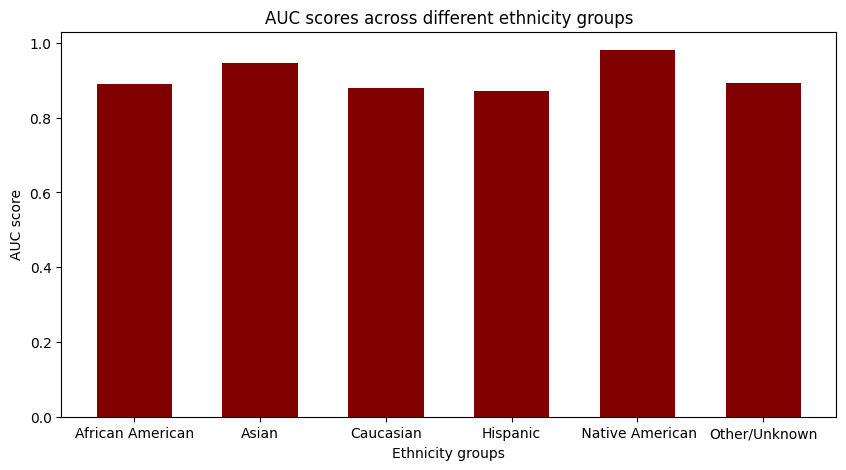

In [67]:
data = {'African American': 0.8892, 'Asian':  0.9460, 'Caucasian': 0.8787,
        'Hispanic': 0.8715, ' Native American': 0.9810, 'Other/Unknown': 0.8917}
ethnicities = list(data.keys())
values = list(data.values())
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(ethnicities, values, color ='maroon',
        width = 0.6)
 
plt.xlabel("Ethnicity groups")
plt.ylabel("AUC score")
plt.title("AUC scores across different ethnicity groups")
plt.show()

# Quantitative evaluation

In [ ]:
chosen_model = "XGBoost"
classifier = xgb_model # xgboost
decision_threshold = best_thresholds_fnrminacc["XGBoost"]
decision_threshold_apache = best_thresholds_fnrminacc["APACHE IV"]

y_pred_proba_test = classifier.predict_proba(X_test)[:,1]
y_pred_test = y_pred_proba_test >= decision_threshold

y_pred_proba_apache_test = y_apache_test[y_apache_test >= 0]
y_pred_apache_test = y_pred_proba_apache_test >= decision_threshold_apache

## Scores (AUC score, ...)

AUC score, 
false positive rate, 
false negative rate, 
false discovery rate, and 
false omission rate

In [ ]:
area_under_curve = roc_auc_score(y_test, y_pred_proba_test)
confusion_matrix_test = confusion_matrix(y_test, y_pred_test)
true_negatives = confusion_matrix_test[0][0]
false_negatives = confusion_matrix_test[1][0]
true_positives = confusion_matrix_test[1][1]
false_positives = confusion_matrix_test[0][1]
false_positive_rate = false_positives / (false_positives + true_negatives)
false_negative_rate = false_negatives / (false_negatives + true_positives)
false_discovery_rate = false_positives / (false_positives + true_positives)
false_omission_rate = false_negatives / (false_negatives + true_negatives)
accuracy = (true_positives + true_negatives) / confusion_matrix_test.flatten().sum()
print(f'''
For {chosen_model}
----
AUC score: {area_under_curve:.3f}
FPR:       {false_positive_rate:.3f}
FNR:       {false_negative_rate:.3f}      
FDR:       {false_discovery_rate:.3f}
FOR:       {false_omission_rate:.3f}
ACC:       {accuracy:.3f}
''')
area_under_curve_apache = roc_auc_score(y_test[y_apache_test >= 0], y_pred_proba_apache_test)
confusion_matrix_apache_test = confusion_matrix(y_test[y_apache_test >= 0], y_pred_apache_test)
true_negatives_apache = confusion_matrix_apache_test[0][0]
false_negatives_apache = confusion_matrix_apache_test[1][0]
true_positives_apache = confusion_matrix_apache_test[1][1]
false_positives_apache = confusion_matrix_apache_test[0][1]
false_positive_rate_apache = false_positives_apache / (false_positives_apache + true_negatives_apache)
false_negative_rate_apache = false_negatives_apache / (false_negatives_apache + true_positives_apache)
false_discovery_rate_apache = false_positives_apache / (false_positives_apache + true_positives_apache)
false_omission_rate_apache = false_negatives_apache / (false_negatives_apache + true_negatives_apache)
accuracy = (true_positives + true_negatives) / confusion_matrix_test.flatten().sum()
print(f'''
For APACHE IV
----
AUC score: {area_under_curve_apache:.3f}
FPR:       {false_positive_rate_apache:.3f}
FNR:       {false_negative_rate_apache:.3f}      
FDR:       {false_discovery_rate_apache:.3f}
FOR:       {false_omission_rate_apache:.3f}
ACC:       {accuracy:.3f}
''')

# Ethnicity based metric evaluation
We calculate the metrics based on each ethnic group for both APACHE IV and our final model

In [71]:
#create unique onehotencoded column values array as the OneHotEncoder() creates them...
ethnicity_columns = [
    'cat__ethnicity_African American',
    'cat__ethnicity_Asian',
    'cat__ethnicity_Caucasian',
    'cat__ethnicity_Hispanic',
    'cat__ethnicity_Native American',
    'cat__ethnicity_Other/Unknown',
    'cat__ethnicity_nan'
]


XGBoost metric calculation:

In [72]:
data_scores_XGBoost = {"Accuracy": {},
                      "ROC AUC": {},
                      "Precision": {},
                      "Recall": {}}

for i, ethnicity in enumerate(ethnicity_columns):
    #get the original ethnicity value from column name
    original_ethnicity = ethnicity.split('_')[-1]
    
    #create index and ethnicity mask for y_val
    mask = (df.loc[y_val.index, 'ethnicity'] == original_ethnicity)

    # make predictions on the validation set
    y_val_pred = xgb_model.predict(X_val)
    y_xgb_pred_proba_val = xgb_model.predict_proba(X_val)[:, 1]

    #Use the mask on y_val and the predictions
    y_val_filtered = y_val[mask]
    
    y_val_pred_filtered = y_val_pred[mask]
    y_val_pred_proba_filtered = y_xgb_pred_proba_val[mask]

    #skip if the array is too small to predict (skips cat__ethnicity_nan because its small)
    if len(y_val_filtered) < 1 or len(y_val_pred_proba_filtered) < 1 or len(y_val_pred_filtered) < 1:
        continue
    
    # calculate evaluation metrics on the validation set
    val_acc = accuracy_score(y_val_filtered, y_val_pred_filtered)
    val_auc = roc_auc_score(y_val_filtered, y_val_pred_proba_filtered)
    val_precision = precision_score(y_val_filtered, y_val_pred_filtered)
    val_recall = recall_score(y_val_filtered, y_val_pred_filtered)

    # Store values in the dict
    data_scores_XGBoost["Accuracy"][original_ethnicity] = val_acc
    data_scores_XGBoost["ROC AUC"][original_ethnicity] = val_auc
    data_scores_XGBoost["Precision"][original_ethnicity] = val_precision
    data_scores_XGBoost["Recall"][original_ethnicity] = val_recall

    # Print the results
    # print(f"Ethnicity: {original_ethnicity}")
    # print(f"Accuracy score: {val_acc:.4f}")
    # print(f"Roc_auc_score: {val_auc:.4f}")
    # print(f"Precision score: {val_precision:.4f}")
    # print(f"Recall score: {val_recall:.4f}")
    # print("\n")

APACHE IV calculation:

In [73]:
data_scores_apache = {"Accuracy": {},
                      "ROC AUC": {},
                      "Precision": {},
                      "Recall": {}}

def applyThreshold(x):
    if (x >= best_thresholds_fnrminacc["APACHE IV"]):
        return 1.0
    else:
        return 0.0

for i, ethnicity in enumerate(ethnicity_columns):
    #get the original ethnicity value from column name
    original_ethnicity = ethnicity.split('_')[-1]
    
    #create index and ethnicity mask for y_val
    mask = (df.loc[y_val.index, 'ethnicity'] == original_ethnicity)

    #Remove entries with negative apache scores
    y_pred_proba_apache_val = y_apache_val[y_apache_val >= 0]
    y_val_filtered = y_val[y_apache_val >= 0]
    y_val_filtered = y_val_filtered[mask]
    
    y_pred_apache_val = y_pred_proba_apache_val.apply(applyThreshold)
    
    #Filter on ethnicity and use the previously created mask for y_val
    y_pred_proba_apache_val_filtered = y_pred_proba_apache_val[mask]
    y_pred_apache_val_filtered = y_pred_apache_val[mask]

    #skip if the array is too small to predict (skips cat__ethnicity_nan because its small)
    if len(y_val_filtered) < 1 or len(y_pred_proba_apache_val_filtered) < 1 or len(y_pred_apache_val_filtered) < 1:
        continue

    # calculate evaluation metrics on the validation set
    val_acc = accuracy_score(y_val_filtered, y_pred_apache_val_filtered)
    val_auc = roc_auc_score(y_val_filtered, y_pred_proba_apache_val_filtered)
    val_precision = precision_score(y_val_filtered, y_pred_apache_val_filtered)
    val_recall = recall_score(y_val_filtered, y_pred_apache_val_filtered)

    # Store values in the dict
    data_scores_apache["Accuracy"][original_ethnicity] = val_acc
    data_scores_apache["ROC AUC"][original_ethnicity] = val_auc
    data_scores_apache["Precision"][original_ethnicity] = val_precision
    data_scores_apache["Recall"][original_ethnicity] = val_recall
    
    # Print the results
    # print(f"Ethnicity: {original_ethnicity}")
    # print(f"Accuracy score: {val_acc:.4f}")
    # print(f"Roc_auc_score: {val_auc:.4f}")
    # print(f"Precision score: {val_precision:.4f}")
    # print(f"Recall score: {val_recall:.4f}")
    # print("\n")

Now we visualize the evaluation data:

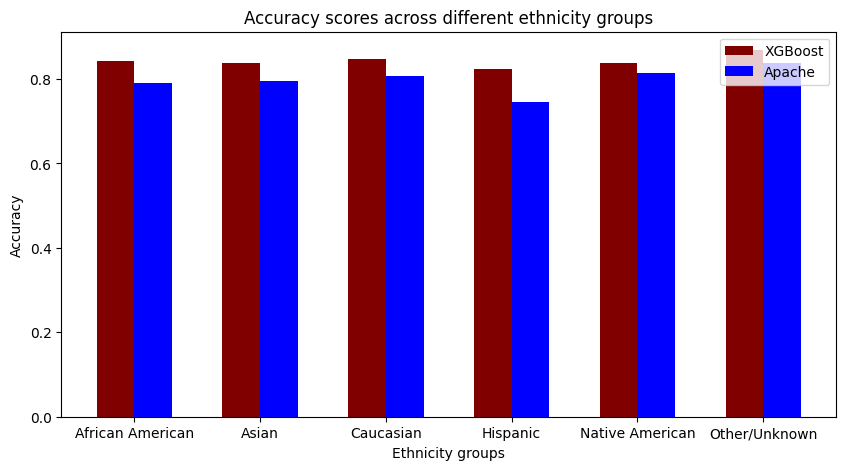

<Figure size 640x480 with 0 Axes>

In [82]:
data1 = data_scores_XGBoost["Accuracy"]
data2 = data_scores_apache["Accuracy"]

ethnicities = list(data1.keys())
values1 = list(data1.values())
values2 = list(data2.values())

# Set width of a bar
bar_width = 0.3

fig = plt.figure(figsize=(10, 5))

# Set the positions of the bars on the x-axis
indices = np.arange(len(ethnicities))
bar1_positions = indices - bar_width / 2
bar2_positions = indices + bar_width / 2

# Creating the bar plots
plt.bar(bar1_positions, values1, color='maroon', width=bar_width, label='XGBoost')
plt.bar(bar2_positions, values2, color='blue', width=bar_width, label='Apache')

# Add labels and title
plt.xlabel("Ethnicity groups")
plt.ylabel("Accuracy")
plt.title("Accuracy scores across different ethnicity groups")

# Set the x-axis tick labels
plt.xticks(indices, ethnicities)

# Adding legend
plt.legend()

# Show the plot
plt.show()

plt.savefig("eth_eval_accuracy.eps")

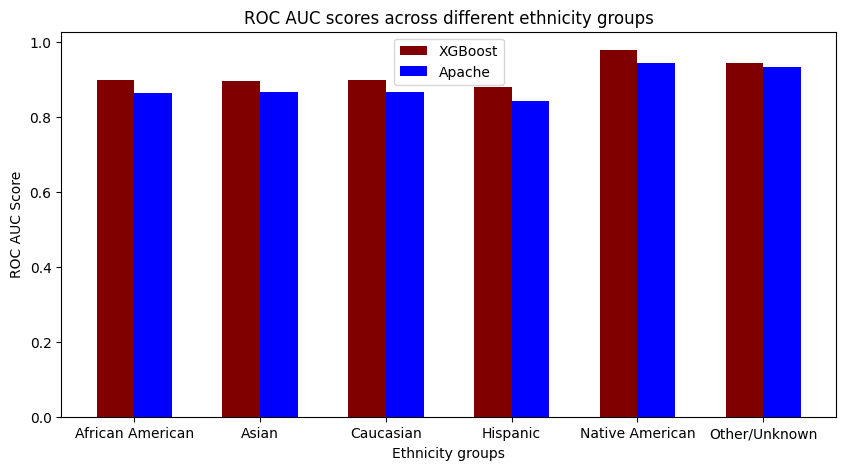

<Figure size 640x480 with 0 Axes>

In [83]:
data1 = data_scores_XGBoost["ROC AUC"]
data2 = data_scores_apache["ROC AUC"]

ethnicities = list(data1.keys())
values1 = list(data1.values())
values2 = list(data2.values())

# Set width of a bar
bar_width = 0.3

fig = plt.figure(figsize=(10, 5))

# Set the positions of the bars on the x-axis
indices = np.arange(len(ethnicities))
bar1_positions = indices - bar_width / 2
bar2_positions = indices + bar_width / 2

# Creating the bar plots
plt.bar(bar1_positions, values1, color='maroon', width=bar_width, label='XGBoost')
plt.bar(bar2_positions, values2, color='blue', width=bar_width, label='Apache')

# Add labels and title
plt.xlabel("Ethnicity groups")
plt.ylabel("ROC AUC Score")
plt.title("ROC AUC scores across different ethnicity groups")

# Set the x-axis tick labels
plt.xticks(indices, ethnicities)

# Adding legend
plt.legend()

# Show the plot
plt.show()

plt.savefig("eth_eval_roc_auc.eps")

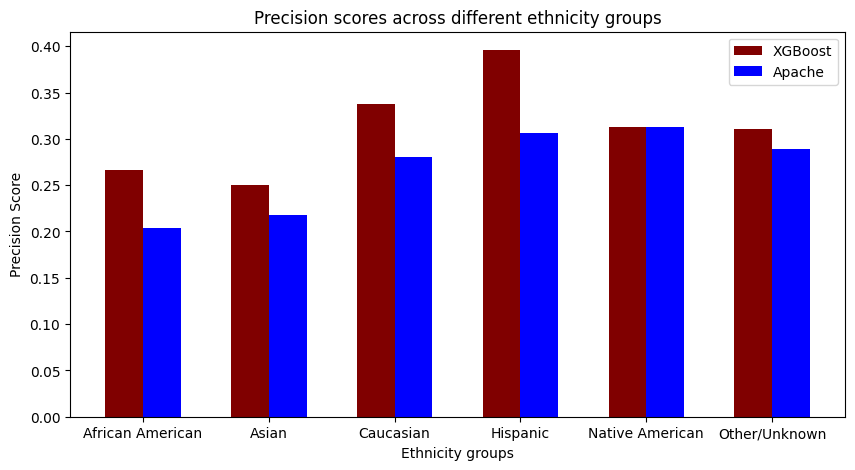

<Figure size 640x480 with 0 Axes>

In [84]:
data1 = data_scores_XGBoost["Precision"]
data2 = data_scores_apache["Precision"]

ethnicities = list(data1.keys())
values1 = list(data1.values())
values2 = list(data2.values())

# Set width of a bar
bar_width = 0.3

fig = plt.figure(figsize=(10, 5))

# Set the positions of the bars on the x-axis
indices = np.arange(len(ethnicities))
bar1_positions = indices - bar_width / 2
bar2_positions = indices + bar_width / 2

# Creating the bar plots
plt.bar(bar1_positions, values1, color='maroon', width=bar_width, label='XGBoost')
plt.bar(bar2_positions, values2, color='blue', width=bar_width, label='Apache')

# Add labels and title
plt.xlabel("Ethnicity groups")
plt.ylabel("Precision Score")
plt.title("Precision scores across different ethnicity groups")

# Set the x-axis tick labels
plt.xticks(indices, ethnicities)

# Adding legend
plt.legend()

# Show the plot
plt.show()

plt.savefig("eth_eval_precision.eps")

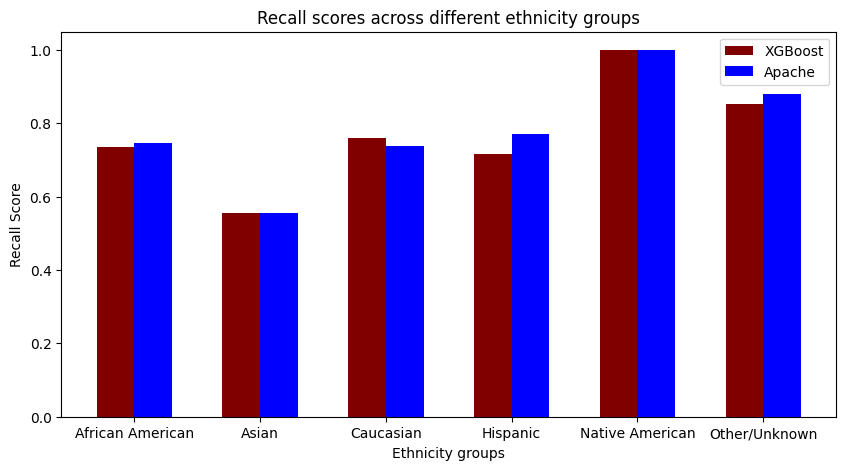

<Figure size 640x480 with 0 Axes>

In [85]:
data1 = data_scores_XGBoost["Recall"]
data2 = data_scores_apache["Recall"]

ethnicities = list(data1.keys())
values1 = list(data1.values())
values2 = list(data2.values())

# Set width of a bar
bar_width = 0.3

fig = plt.figure(figsize=(10, 5))

# Set the positions of the bars on the x-axis
indices = np.arange(len(ethnicities))
bar1_positions = indices - bar_width / 2
bar2_positions = indices + bar_width / 2

# Creating the bar plots
plt.bar(bar1_positions, values1, color='maroon', width=bar_width, label='XGBoost')
plt.bar(bar2_positions, values2, color='blue', width=bar_width, label='Apache')

# Add labels and title
plt.xlabel("Ethnicity groups")
plt.ylabel("Recall Score")
plt.title("Recall scores across different ethnicity groups")

# Set the x-axis tick labels
plt.xticks(indices, ethnicities)

# Adding legend
plt.legend()

# Show the plot
plt.show()

plt.savefig("eth_eval_recall.eps")

## Visualizations (ROC and calibration)

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].plot([0, 1], [0, 1], "k--", label="Chance level (AUC = 0.5)")
RocCurveDisplay.from_predictions(
    y_test[y_apache_test >= 0], 
    y_pred_proba_apache_test, 
    name=f"APACHE IV",
    ax=ax[0])
RocCurveDisplay.from_predictions(
    y_test, 
    y_pred_proba_test,
    name=chosen_model,
    ax=ax[0])
ax[0].axis("square")
ax[0].set_xlabel("False Positive Rate")
ax[0].set_ylabel("True Positive Rate")
ax[0].set_title("ROC (test)")
ax[0].legend()

CalibrationDisplay.from_predictions(
    y_test[y_apache_test >= 0], 
    y_pred_proba_apache_test,
    n_bins=10,
    name="APACHE IV",
    ax=ax[1]
).plot
CalibrationDisplay.from_predictions(
    y_test, 
    y_pred_proba_test,
    n_bins=10,
    name=chosen_model,
    ax=ax[1]
).plot
ax[1].axis("square")
ax[1].set_xlabel("Predicted probability (binned)")
ax[1].set_ylabel("Ratio of positives")
ax[1].set_title("Calibration (test)")

plt.show()

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ConfusionMatrixDisplay.from_predictions(
    y_test, 
    y_pred_test,
    normalize='true',
    ax=ax[0]
)
ConfusionMatrixDisplay.from_predictions(
    y_test[y_apache_test >= 0], 
    y_pred_apache_test, 
    normalize='true',
    ax=ax[1]
)
ax[0].set_title("XGBoost\nConfusion matrix (test)")
ax[1].set_title("APACHE IV\nConfusion matrix (test)")
plt.show()

# Explainability

In [ ]:
shap.initjs()

explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test)

shap.summary_plot(shap_values, X_test, plot_type="bar")